## Pre-requisites
Env: python 3.6, latest anaconda3 distribution  
Before running this notebook, make sure you have the following packages installed.
- ta-lib  
https://github.com/mrjbq7/ta-lib
- kaggle api  
https://github.com/Kaggle/kaggle-api
- joblib  
conda install joblib  
Windows users are recommended to download and install the package directly from the github page https://github.com/joblib/joblib, as a Windows-specific bug was fixed in the recent master release but has not been pushed to conda repo yet.

In [1]:
import pandas as pd
import numpy as np
import talib
import os
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.finance as mpf
import random
from joblib import Parallel, delayed

%matplotlib inline

D:\Program_Files\Anaconda3\envs\stats\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


### Download Kaggle datasets

In [2]:
# !kaggle datasets download -d dgawlik/nyse -p ./datasets

### Load the data

In [3]:
fundamentals = pd.read_csv("./datasets/fundamentals.csv", parse_dates=['Period Ending'])
prices = pd.read_csv("./datasets/prices.csv", parse_dates=['date'])
prices_adj = pd.read_csv("./datasets/prices-split-adjusted.csv", parse_dates=['date'])
securities = pd.read_csv("./datasets/securities.csv", parse_dates=['Date first added'])

In [4]:
symbols = sorted(prices_adj['symbol'].unique())
prices_adj.set_index(['symbol', 'date'], inplace=True, drop=True)
prices_adj.sort_index(inplace=True)

### Plotting

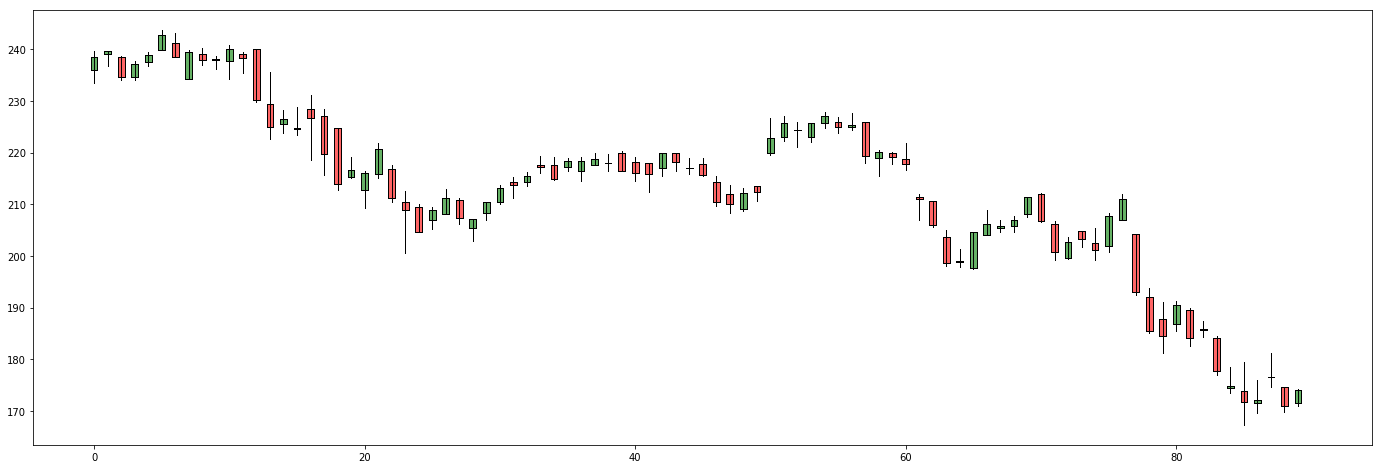

In [5]:
data = prices_adj.loc['BLK', ['open','close','high','low','volume']][:90]
fig = plt.figure(figsize=(24, 8))
ax = fig.add_subplot(1, 1, 1)
mpf.candlestick2_ochl(ax, data['open'], data['close'], data['high'], data['low'], width=0.5, colorup='green', colordown='red', alpha=0.6)

### Normalize the prices entries using the t-1 close price  
- Effectively it's the daily return calculated as the difference of the log(price)  
- The price movement is modeled as a Wiener process (aka a random walk) in this analysis. Under this assumption,  
    - Return has normal distribution
    - Sometimes people use the Poisson process to model jumps, I stick with Wiener process for its simplicity.  
- Log transformation is performed to calculate the return  
    - Normally $return = (price_{t} - price_{t-1}) / price_{t-1}$, it can be approximate as $return = log(price_{t})-log(price_{t-1})$. 
    - The later can be more efficiently calculated, especially when calculating the cumulative.

In [6]:
ret = prices_adj.copy()

# Log transfrom the prices   
for col in ['open','close','low','high']:
    ret[col] = np.log(ret[col])
    
# Get the close price of the previous day
ret['close_m1'] = ret['close'].shift(1)

# Calculate normalize the prices using t-1 close price
ret.eval("""
            open = open - close_m1
            close = close - close_m1
            high = high - close_m1
            low = low - close_m1
         """,
             inplace = True)

# Drop close_m1
ret.drop(labels=['close_m1'], axis='columns', inplace=True)

# Drop the first entry for each ticker
idx = ret.groupby('symbol').head(1).index
ret.drop(labels=idx, axis='index', inplace=True)

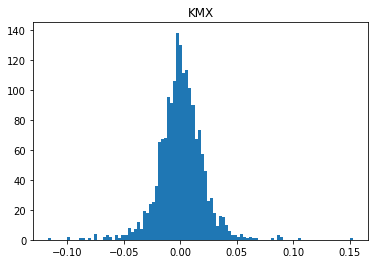

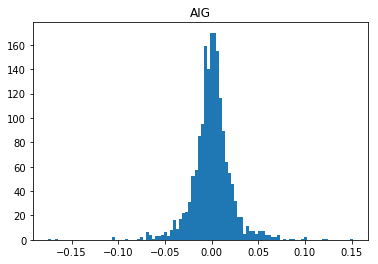

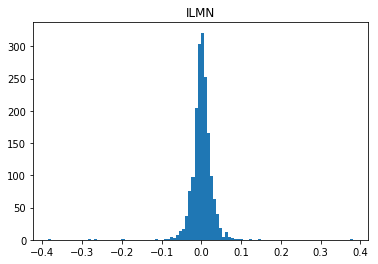

In [7]:
# The normal distribution assumption

for i in random.choices(symbols, k=3):
    plt.hist(ret.loc[i, 'close'], bins=100)
    plt.title(i)
    plt.show()

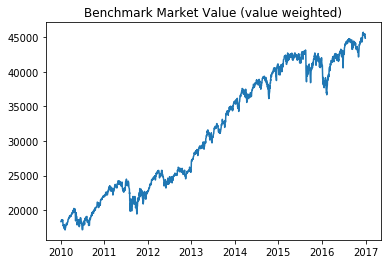

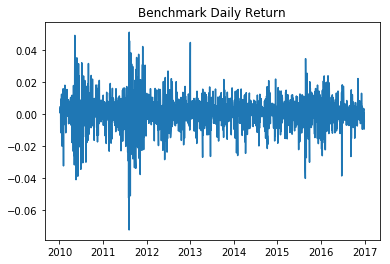

In [8]:
# Calculate the index return (baseline)

df = prices_adj.reset_index('symbol').sort_index()
bench = df.groupby(df.index)[['close']].sum()
plt.plot(bench)
plt.title("Benchmark Market Value (value weighted)")
plt.show()

bench_ret = np.log(bench) - np.log(bench.shift(1))
plt.plot(bench_ret)
plt.title("Benchmark Daily Return")
plt.show()

del(df)

In [9]:
# Calculate the daily active return (stock return - benchmark return)

ret = ret.swaplevel().sort_index()
ret['active'] = ret['close'] - bench_ret['close']

ret = ret.swaplevel().sort_index()

In [10]:
# Some feature engineering

def calc_features(symbol):
        
    df = ret.loc[[symbol]].copy()
        
    for period in [5, 10, 20, 30, 60, 90]:
        # Momentum (cumulative return of the previous n days)
        exec("""df['cum_ret_%s'] = df['close'].rolling(period).sum().values"""  % period)

        # Standard deviation
        exec("""df['std_%s'] = df['close'].rolling(period).std().values"""  % period)

        # relative volume (t0 : average over the period (t-n, t-1))
        exec("""df['vol_to_avg_%s'] = (df['volume'] / df['volume'].shift(1).rolling(period).mean()).values"""  % period)

        # relative volume (t0 : median over the period (t-n, t-1))
        exec("""df['vol_to_med_%s'] = (df['volume'] / df['volume'].shift(1).rolling(period).median()).values"""  % period)

        # Highs and lows
        exec("""df['high_%s'] = df['high'].rolling(period).max().values"""  % period)
        exec("""df['low_%s'] = df['low'].rolling(period).min().values"""  % period)

    return df

# Kick it off with multi threading
out = Parallel(n_jobs=-1, backend="threading")(delayed(calc_features)(s) for s in symbols)
    
features = pd.concat(out)
features.drop(['volume'], axis=1, inplace=True)
features = features.swaplevel().sort_index()
del(out)

In [11]:
# Check the result
features.tail()

open     close       low      high    active  \
date       symbol                                                     
2016-12-30 YHOO    0.002068  0.000776 -0.005450  0.009274  0.005482   
           YUM     0.004704 -0.004726 -0.007414  0.004860 -0.000020   
           ZBH    -0.001837 -0.002903 -0.006300  0.004146  0.001803   
           ZION    0.006522  0.005825 -0.002340  0.012079  0.010532   
           ZTS     0.000373 -0.001680 -0.006549  0.002236  0.003026   

                   cum_ret_5     std_5  vol_to_avg_5  vol_to_med_5    high_5  \
date       symbol                                                              
2016-12-30 YHOO     0.004406  0.004696      1.135134      1.516779  0.010549   
           YUM     -0.011305  0.003474      1.265084      1.327635  0.010600   
           ZBH      0.015921  0.004856      1.043976      1.139614  0.011064   
           ZION    -0.016133  0.009271      1.490273      1.558710  0.012079   
           ZTS      0.005057  0.005744      1.199413      1.264833  0.009716   

                     ...     vol_to_avg_60  vol_to_med_60   high_60    low_60  \
date       symbol    ...                                                        
2016-12-30 YHOO      ...          0.659878       0.824940  0.029782 -0.067231   
           YUM       ...          0.431059       0.543160  0.036956 -0.028780   
           ZBH       ...          0.497139       0.615783  0.040499 -0.164802   
           ZION      ...          0.604266       0.666483  0.078332 -0.058161   
           ZTS       ...          0.489298       0.554381  0.075981 -0.047813   

                   cum_ret_90    std_90  vol_to_avg_90  vol_to_med_90  \
date       symbol                                                       
2016-12-30 YHOO     -0.096790  0.015226       0.629206       0.767233   
           YUM      -0.024755  0.010374       0.440459       0.551526   
           ZBH      -0.229095  0.020745       0.583125       0.733173   
           ZION      0.385225  0.016449       0.616697       0.666850   
           ZTS       0.043527  0.013283       0.493421       0.536132   

                    high_90    low_90  
date       symbol                      
2016-12-30 YHOO    0.035633 -0.067231  
           YUM     0.036956 -0.028780  
           ZBH     0.040499 -0.164802  
           ZION    0.078332 -0.058161  
           ZTS     0.075981 -0.047813  

[5 rows x 41 columns]

### Define train and test data

Due to the nature of the panel data, the train and test data is splitted on a rolling basis. for example, during the training stage I use 01/05/2010's features as the X and 01/06/2010's return as the y to fit a model. To test this model, I need to use 01/06/2010's features as the test data and 01/07/2010's return as the test label to evaluate the model. This process is repeated for all the dates.

In [12]:
dates = features.reset_index()[['date']].drop_duplicates().reset_index(drop=True)
dates.rename_axis({'date': 'X_train'}, axis=1, inplace=True)
dates['y_train'] = dates['X_train'].shift(-1)
dates['X_test'] = dates['X_train'].shift(-1)
dates['y_test'] = dates['X_test'].shift(-1)
dates['trade_date'] = dates['X_test']
dates.set_index('trade_date', inplace=True)

dates.dropna(axis=0, inplace=True)

In [13]:
dates.head()

,X_train,y_train,X_test,y_test
trade_date,,,,
2010-01-06,2010-01-05,2010-01-06,2010-01-06,2010-01-07
2010-01-07,2010-01-06,2010-01-07,2010-01-07,2010-01-08
2010-01-08,2010-01-07,2010-01-08,2010-01-08,2010-01-11
2010-01-11,2010-01-08,2010-01-11,2010-01-11,2010-01-12
2010-01-12,2010-01-11,2010-01-12,2010-01-12,2010-01-13


In [14]:
dates.tail()

,X_train,y_train,X_test,y_test
trade_date,,,,
2016-12-22,2016-12-21,2016-12-22,2016-12-22,2016-12-23
2016-12-23,2016-12-22,2016-12-23,2016-12-23,2016-12-27
2016-12-27,2016-12-23,2016-12-27,2016-12-27,2016-12-28
2016-12-28,2016-12-27,2016-12-28,2016-12-28,2016-12-29
2016-12-29,2016-12-28,2016-12-29,2016-12-29,2016-12-30


In [15]:
def train_test_split(date):

    X_train = features.loc[dates.loc[date, 'X_train']].dropna(axis=0)
    y_train = features.loc[dates.loc[date, 'y_train'],'open'].dropna(axis=0)
    X_test = features.loc[dates.loc[date, 'X_test']].dropna(axis=0)
    y_test = features.loc[dates.loc[date, 'y_test'],'open'].dropna(axis=0)

    # Keep only the symbols that are in both sets
    X_train = X_train.loc[X_train.index.intersection(y_train.index)].sort_index()
    y_train = y_train.loc[y_train.index.intersection(X_train.index)].sort_index()
    X_test = X_test.loc[X_test.index.intersection(y_test.index)].sort_index()
    y_test = y_test.loc[y_test.index.intersection(X_test.index)].sort_index()

    # Make a binary y (1 for positive return, 0 for negative return)
    y_bin_train = (y_train > 0) * 1
    y_bin_test = (y_test > 0) * 1

    return X_train.as_matrix(), y_train.as_matrix(), y_bin_train.as_matrix(), X_test.as_matrix(), y_test.as_matrix(), y_bin_test.as_matrix()
#     return X_train, y_train, y_bin_train, X_test, y_test, y_bin_test

### Random forest

In [52]:
%%time
regr = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1, bootstrap=True)

def evaluate_rf_regr(date):
    X_train, y_train, y_bin_train, X_test, y_test, y_bin_test = train_test_split(date)
    
    try:
        regr.fit(X_train, y_train)
    except ValueError:
        return
        
    y_pred = regr.predict(X_test)
    
    # Calculate the accuracy of the direction prediction
    accu_d = sum(y_pred * y_test > 0) / len(y_test)
    
    # Create a long only strategy to equally buy the stock with predicted positive overnight return
    if len(y_test[y_pred > 0]) > 0:
        strat_return = np.mean(y_test[y_pred > 0])
    else:
        strat_return = 0
    return [date, accu_d, strat_return]


out = []
for date in dates.index[90:]:
    out.append(evaluate_rf_regr(date))

# Kick it off with multi threading
# out = Parallel(n_jobs=-1, timeout=60)(delayed(evaluate_rf_regr)(date) for date in dates.index[90:200])

result_rf_regr = np.array(out)

Wall time: 6min 7s


In [50]:
result_rf_regr = np.array(out)


In [ ]:
%%time
regr = RandomForestClassfier(n_estimators=10, random_state=1, n_jobs=-1, bootstrap=True)

def evaluate_rf_regr(date):
    X_train, y_train, y_bin_train, X_test, y_test, y_bin_test = train_test_split(date)
    
    try:
        regr.fit(X_train, y_bin_train)
    except ValueError:
        return
        
    y_pred = regr.predict(X_test)
    
    # Calculate the accuracy of the direction prediction
    accu_d = sum(y_pred + y_bin_test != 1) / len(y_test)
    
    # Create a long only strategy to equally buy the stock with predicted positive overnight return
    strat_return = np.mean(y_test[y_pred == 1])
    
    return [date, accu_d, strat_return]


# out = []
# for date in dates.index:
#     out.append(evaluate_rf_regr(date))

# Kick it off with multi threading
out = Parallel(n_jobs=-1)(delayed(evaluate_rf_regr)(date) for date in dates.index)



In [ ]:
y_test[:6]

In [ ]:
y_pred * y_test

### Some technical analysis indicators

In [ ]:
from talib.abstract import STOCH

In [ ]:
for s in symbols[:5]:
    
    """ Momentum using close prices """
    prices_adj.loc[[s], 'MOM_20'] = talib.MOM(prices_adj.loc[[s], 'close'], timeperiod=20)
    
    """ Simple moving average of the close prices """
    prices_adj.loc[[s], 'MA_5'] = talib.SMA(prices_adj.loc[[s], 'close'], timeperiod=5)
    prices_adj.loc[[s], 'MA_10'] = talib.SMA(prices_adj.loc[[s], 'close'], timeperiod=10)
    prices_adj.loc[[s], 'MA_20'] = talib.SMA(prices_adj.loc[[s], 'close'], timeperiod=20)
    prices_adj.loc[[s], 'MA_50'] = talib.SMA(prices_adj.loc[[s], 'close'], timeperiod=50)
    prices_adj.loc[[s], 'MA_100'] = talib.SMA(prices_adj.loc[[s], 'close'], timeperiod=100)
    
    """ Bollinger bands """
    upper, middle, lower = talib.BBANDS(prices_adj.loc[[s], 'close'], matype=talib.MA_Type.T3)
    prices_adj.loc[[s], 'BBANDS.upper'] = upper
    prices_adj.loc[[s], 'BBANDS.middle'] = middle
    prices_adj.loc[[s], 'BBANDS.lower'] = lower
    
    """ Stochastic """
    # uses high, low, close (default)
    prices_adj.loc[[s], ['STOCH.slowk','STOCH.slowd']] = STOCH(prices_adj.loc[s], 5, 3, 0, 3, 0).as_matrix()

    # uses high, low, open instead
#     prices_adj.loc[[s], ['STOCH.slowk','STOCH.slowd']] = STOCH(prices_adj.loc[s], 5, 3, 0, 3, 0, 
#                                                                prices=['high', 'low', 'open']).as_matrix()

    

In [ ]:
symbols[:3]

In [ ]:
?train_test_split()

In [ ]:
securities.groupby('GICS Sector')['Ticker symbol'].count()